# High-dimensional analysis with pytometry
## Table of contents
1. [What is pytometry?](#pytometry)
2. [Reading in data](#reading-in-data)
3. [Transforming channel values](#transforming-channel-values)
4. [Adding sample metadata](#adding-sample-metadata)
5. [Batch alignment](#batch-alignment)  
6. [Clustering](#clustering)  
7. [Batch alignment](#batch-alignment)  

## What is pytometry?
`Pytometry` is a Python package that provides tools for reading in flow cytometry data and applying pre-processing tools. While it provides methods for compensation and transformation (just like `flowkit`), it's focus is on the high-dimensional and unsupervised analysis of cytometry data. 'Pytometry' uses a data structure called `AnnData` ("Annotated Data") that is commonly used for single cell analysis, most notably the `scanpy` package often used for RNAseq analysis. This allows us to apply algorithms and visualisations to our cytometry data from the transcriptomics world. The `AnnData` structure may seem a little intimiating at first, but we'll learn as we go, and hopefully you'll see it's just a collection of matrices/DataFrames of different kinds of data, all linked back to the data by the sample metadata.

In the diagram below (from the `AnnData` package's documentation): 
- `X` is the expression matrix where each row is an event and each column is a variable
- `var` is a DataFrame of metadata about each variable in `X`
- `obs` is a DataFrame of metadata about each observation (event) in `X`
- `uns` is a dictionary of unstructured metadata that doesn't fit anywhere else

There are some other subfields in the diagram that either aren't relevant for not, or we'll come back to them later.

<img alt="annData" src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width=500>

Note: `pytometry` assumes your data have already been cleaned of debris, dead cells, and doublets. Most people will find it easiest to do this using software like FlowJo and exporting cleaned .fcs or .csv files. Alternatively this can be done in `flowkit` as in the previous tutorial.

We start by importing the packages we're going to need. There are quite a lot of them in this tutorial so you may wish to take note of the alias we use for each. Don't forget that before using these packages you will need to install them, for example using `pip install bokeh pytometry` in a terminal/powershell.

In [370]:
import scanpy as sc             # for single cell analysis
import anndata as ann           # for annotated data structure
import cytonormpy as cnp        # for correcting batch effects
import pandas as pd             # for pandas dataframes
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for more plotting functions
import joypy                    # for making ridgeplots
import pytometry as pm          # for high-dim cytometry functions
import os                       # for working with directories

## Reading in data
For this tutorial, you should have the 16 example .fcs files in the folder data/clean from your working/project directory. You can check this using the `os.listdir()` function as below. You should see the same output as shown here.

In [371]:
path = 'data/clean/'
files = os.listdir(path)
files

['Mock_01_A.fcs',
 'Mock_02_A.fcs',
 'Mock_03_A.fcs',
 'Mock_04_A.fcs',
 'Mock_05_B.fcs',
 'Mock_06_B.fcs',
 'Mock_07_B.fcs',
 'Mock_08_B.fcs',
 'sample_details.csv',
 'Virus_01_A.fcs',
 'Virus_02_A.fcs',
 'Virus_03_A.fcs',
 'Virus_04_A.fcs',
 'Virus_05_B.fcs',
 'Virus_06_B.fcs',
 'Virus_07_B.fcs',
 'Virus_08_B.fcs']

We'll make use of that .csv file later, but for now let's get a list containing just the .fcs file names.

In [372]:
files = [fileID for fileID in files if fileID.endswith(".fcs")]
files

['Mock_01_A.fcs',
 'Mock_02_A.fcs',
 'Mock_03_A.fcs',
 'Mock_04_A.fcs',
 'Mock_05_B.fcs',
 'Mock_06_B.fcs',
 'Mock_07_B.fcs',
 'Mock_08_B.fcs',
 'Virus_01_A.fcs',
 'Virus_02_A.fcs',
 'Virus_03_A.fcs',
 'Virus_04_A.fcs',
 'Virus_05_B.fcs',
 'Virus_06_B.fcs',
 'Virus_07_B.fcs',
 'Virus_08_B.fcs']

The next step is to read these .fcs files into a list of `AnnData` objects. First we create an empty list that will hold the data, then we iterate over each filename, reading in the data with the `pm.io.read_fcs()` function, removing unwanted parameters with the `pm.pp.split_signal()` function, then adding that data to the list using the `append()` method. If you call `?pm.pp.split_signal` you'll see this function removes any non-area parameters if `data_type = 'facs'` and removes any non-element parameters if `data_type = 'cytof'`.

In [373]:
adatas = []

for fileID in files:

    adata = pm.io.read_fcs(path + fileID)

    pm.pp.split_signal(
        adata, 
        var_key   = "channel", 
        data_type = "facs"
    )

    adatas.append(adata)

We can subset `adatas` just like any list. If we look at just the first element, we're told it's an `AnnData` object with 10,000 events and 8 parameters. 

In [374]:
adatas[0]

AnnData object with n_obs × n_vars = 10000 × 8
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    uns: 'meta'

We're also told this object has a DataFrame of variable-level metadata (`var`), and some unstructured metadata (`uns`). We can access the variable-level metadata by calling the `var` attribute, and we see we get a DataFrame with some information about each parameter in the original .fcs file. The unstructured metadata just contains the original .fcs file keyword data, and can be accessed using the `.uns` attribute.

In [375]:
adatas[0].var

n    channel   marker  $PnB $PnE $PnG    $PnR signal_type
CD3e     1  PECy5-5-A     CD3e    32  0,0  1.0  262144        area
CD16-32  2    PECy7-A  CD16-32    32  0,0  1.0  262144        area
Ly6G     3    DL800-A     Ly6G    32  0,0  1.0  262144        area
CD45     4    AF700-A     CD45    32  0,0  1.0  262144        area
CD48     5   APCCy7-A     CD48    32  0,0  1.0  262144        area
CD11b    6   BUV395-A    CD11b    32  0,0  1.0  262144        area
B220     7   BUV737-A     B220    32  0,0  1.0  262144        area
Ly6C     8    BV605-A     Ly6C    32  0,0  1.0  262144        area

In [376]:
adatas[0].uns

OrderedDict([('meta',
              {'__header__': {'FCS format': 'FCS3.1',
                'text start': 256,
                'text end': 909,
                'data start': 910,
                'data end': 320909,
                'analysis start': 0,
                'analysis end': 0},
               '$BEGINANALYSIS': '0',
               '$BEGINDATA': '910',
               '$BEGINSTEXT': '0',
               '$BYTEORD': '1,2,3,4',
               '$DATATYPE': 'F',
               '$ENDANALYSIS': '0',
               '$ENDDATA': '320909',
               '$ENDSTEXT': '0',
               '$MODE': 'L',
               '$NEXTDATA': 0,
               '$PAR': 8,
               '$TOT': 10000,
               'channels':         $PnN     $PnS  $PnB $PnE $PnG    $PnR
               n                                            
               1  PECy5-5-A     CD3e    32  0,0  1.0  262144
               2    PECy7-A  CD16-32    32  0,0  1.0  262144
               3    DL800-A     Ly6G    32  0,0  1.0  

At present our data are stored as a list of `AnnData`s but it will be more convenient if we can merge these into a single master `AnnData`. We can achieve this using the `.concat()` method. The `label` argument defines the name of the new column in the observation-level metadata (`obs`) that will indicate the filename each event belongs to, and the `keys` argument defines what these values will be. The `merge = 'same'` argument tells the function to keep only the `var` and `uns` metadata if it is the same for all samples. This ensures that all samples have the same parameters, but results in the `uns` matrix being dropped as this is different for each sample (but we don't mind that).

In [397]:
adata_all = ann.concat(
    adatas, 
    label = 'filename', 
    keys  = files, 
    merge = 'same'
)

adata_all

c:\Python_3.10.2\lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'

Let's take a look at this observation-level metadata I just mentioned. We can view it by calling the `obs` attribute of our object. At present we just have the `filename` column we created to indicate the file each even belongs to. Later we will add more metadata like experimental group and batch.

In [378]:
adata_all.obs

filename
0      Mock_01_A.fcs
1      Mock_01_A.fcs
2      Mock_01_A.fcs
3      Mock_01_A.fcs
4      Mock_01_A.fcs
...              ...
9995  Virus_08_B.fcs
9996  Virus_08_B.fcs
9997  Virus_08_B.fcs
9998  Virus_08_B.fcs
9999  Virus_08_B.fcs

[160000 rows x 1 columns]

As a quick sense-check, let's see how many events we have for each value of the `filename` column in `obs`:

In [379]:
adata_all.obs['filename'].value_counts()

Mock_01_A.fcs     10000
Mock_02_A.fcs     10000
Mock_03_A.fcs     10000
Mock_04_A.fcs     10000
Mock_05_B.fcs     10000
Mock_06_B.fcs     10000
Mock_07_B.fcs     10000
Mock_08_B.fcs     10000
Virus_01_A.fcs    10000
Virus_02_A.fcs    10000
Virus_03_A.fcs    10000
Virus_04_A.fcs    10000
Virus_05_B.fcs    10000
Virus_06_B.fcs    10000
Virus_07_B.fcs    10000
Virus_08_B.fcs    10000
Name: filename, dtype: int64

We can see we have 10,000 events per file. We won't always have the same number of events per sample, but it's good to check we have what we expect, and to ensure we don't have files with too few events.

## Transforming channel values
If your data were exported from FlowJo, then all the parameters will be linear. In order for our dimension reduction and clustering algorithms to provide meaningful insights, we need to transform our fluorescence/metal parameters. `Pytometry` provides a few common transformations such as *biexponential*, *logicle*, and *asinh*. The asinh (inverse hyperbolic sin) transformation is almost exclusively used for mass cytometry data, while any of these transformations may be applied to fluorescence cytometry data. You can experiment with different transformations, but for today we will use biexponential.

We do that using the `normalize_biexp()` function, giving the `AnnData` object, and s eries of parameters to the transformation. You can experiment with these paremeters, but I took these particular values directly from FlowJo. There is also a `normalize_autologicle()` function for automatically choosing the parameters of a logicle transformation, but I'll let you experiment with that one. These functions modify the values of the axisting `AnnData` object in place.

In [398]:
pm.tl.normalize_biexp(
    adata_all,
    negative  = 0,
    width     = -100,
    positive  = 3.71,
    max_value = 65536
)

#pm.tl.normalize_autologicle(adata_all)

To check our choice of transformation is suitable, it’s a good idea to plot each transformed parameter. A quick way to check if our negative populations are squeezed or split by the transformation, is to create ridge plots (sometime called joyplots). We do this using the `joyplot()` function from the package of the same name. This function doesn't accept `AnnData` objects as input, so we convert the expression data to a DataFrame using `to_df()` then randomly sample 10,000 events to speed the plotting up. To the `column` argument we give a list of variable names we access from the `var_names` attribute (converting it to a list as is expected by `joyplot()`), where every variable will be plotted as a separate distribution. The `overlap` argument just controls how much the distributions overlap and you can experiment with this.


I start by using the do.subsample() function to randomly sample 10,000 events from the data (just to speed things up). Next, I use lapply() to apply a function to every element in our transformed_cols vector. The function I apply is an anonymous function that calls make.colour.plot() on the data, iterating over each element of the transformed_cols vector as the x variable, and fixing “AF700_CD45_asinh” as the y variable.

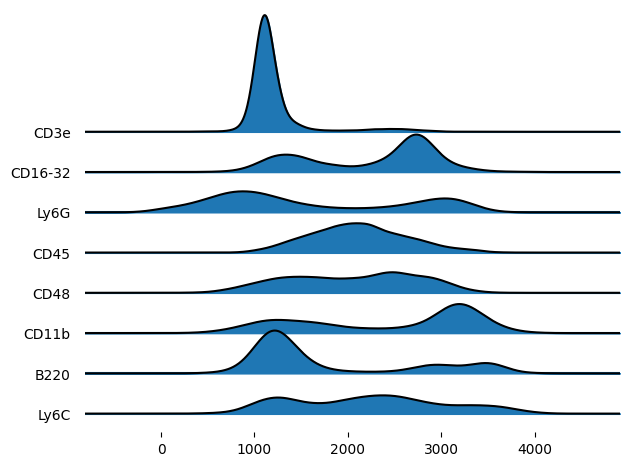

In [381]:
p = joypy.joyplot(
    adata_all.to_df().sample(10_000),
    column  = adata.var_names.to_list(),
    overlap = 1.5
)

Those negative populations look ok, but looking at bivariate plots is a good idea too. Below, we use `seaborn`'s `histplot()` function for plotting a 2D histogram of CD45 against every other parameter. We extract the expression data as a `numpy` array by calling the `X` (capital X) attribute from our `AnnData` object (or we could have extracted it as a DataFrame as we did above). We iterate over the parameters, subsetting for the column for the current parameter.

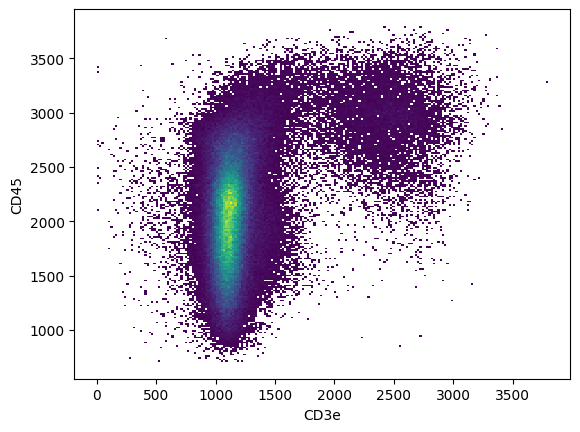

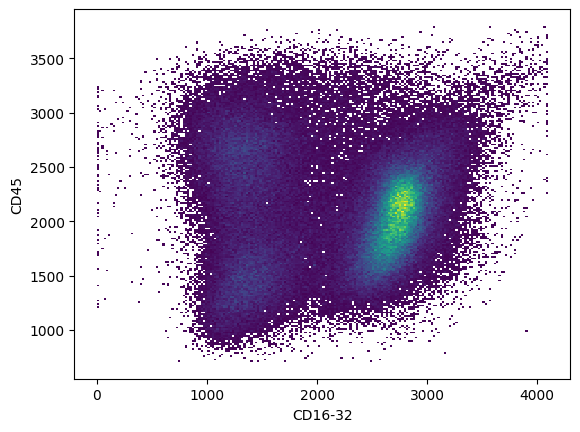

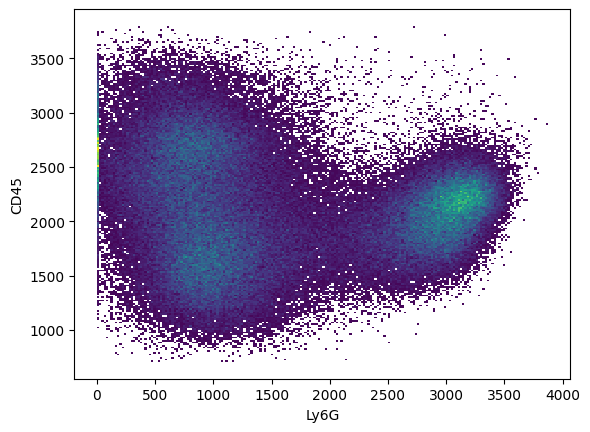

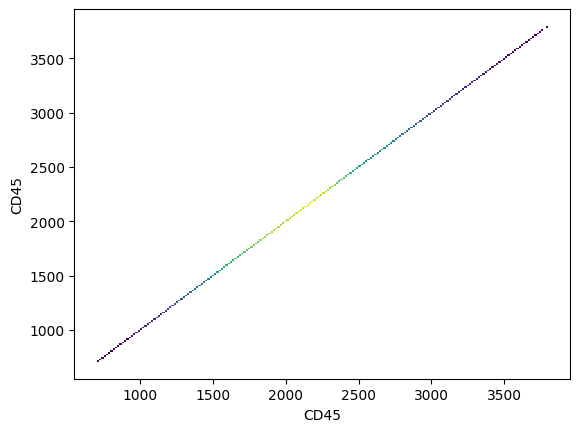

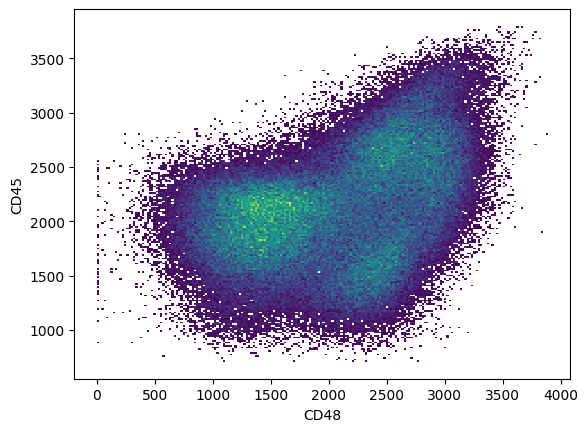

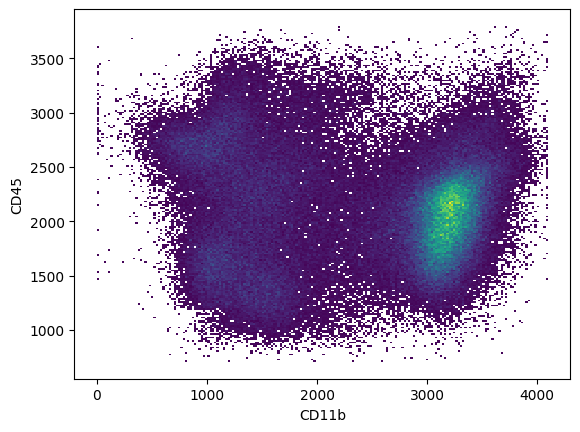

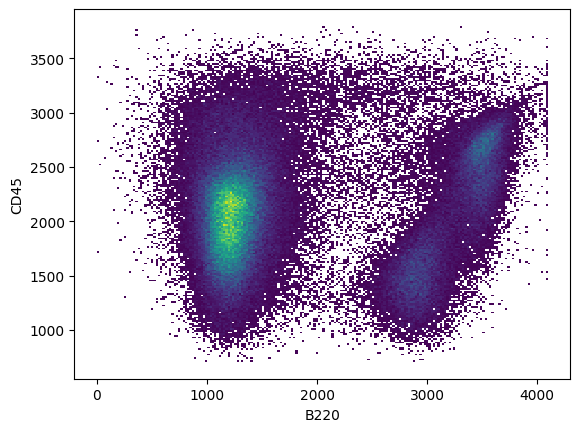

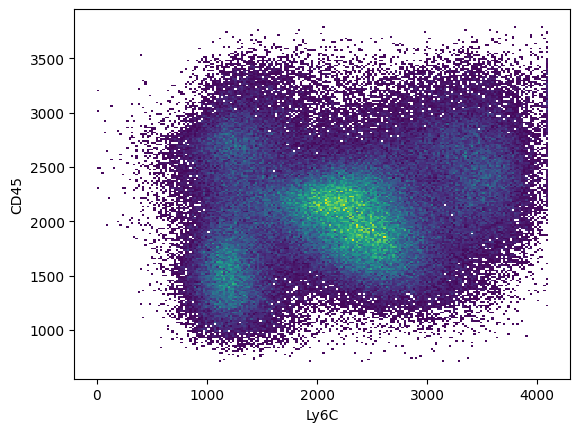

In [382]:
for idx, name in enumerate(adata_all.var_names):
    p = sns.histplot(
        x = adata_all.X[:, idx],
        y = adata_all.X[:, 3],
        bins = 200,
        cmap = 'viridis'
    )

    plt.xlabel(name)
    plt.ylabel('CD45')
    plt.show()

After inspecting each of the plots, we may wish to go back and change our transformation. This transformation looks fine, so we’ll continue.

## Adding sample metadata
Often, we will have sample metadata we wish to include in our analysis that couldn’t read in as part of our .fcs files. This might include sample identifiers and grouping variables such as treatment, concentration, and time. It’s easy to add this information to our `AnnData` object by manually creating a .csv file with the relevant information, and merging this with the `obs` DataFrame.

In your `data/clean/` directory, you should have the file "sample_details.csv" that contains the metadata for this example. If you open the file as a spreadsheet, you'll see it contains the columns:

- filename
- sample
- group
- batch_label
- batch
- reference

It doesn’t need all of these, and could contain more, depending on what variables you want to use to annotate your samples (you could include donor age, for example). However note that (at the time of writing this) the cytonorm algorithm does expect the column `batch` to contain only integers and the column `reference` to containg the value `'ref'` for reference controls, and `'other'` for non-reference controls (more on all of this later).

We read this .csv file in as a DataFrame and merge it with the `obs` DataFrame, matching the metadata between the files using the `filename` column. You can think of it as taking each row in `obs` in turn, looking at the `filename`, then grabbing the metadata corresponding to that `filename` in `metadata`.

In [399]:
metadata = pd.read_csv('data/clean/sample_details.csv')
metadata

filename     sample  group batch_label  batch reference
0    Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
1    Mock_02_A.fcs  Mock_02_A   Mock           A      1     other
2    Mock_03_A.fcs  Mock_03_A   Mock           A      1     other
3    Mock_04_A.fcs  Mock_04_A   Mock           A      1     other
4   Virus_01_A.fcs   WNV_01_A  Virus           A      1     other
5   Virus_02_A.fcs   WNV_02_A  Virus           A      1     other
6   Virus_03_A.fcs   WNV_03_A  Virus           A      1     other
7   Virus_04_A.fcs   WNV_04_A  Virus           A      1     other
8    Mock_05_B.fcs  Mock_05_B   Mock           B      2       ref
9    Mock_06_B.fcs  Mock_06_B   Mock           B      2     other
10   Mock_07_B.fcs  Mock_07_B   Mock           B      2     other
11   Mock_08_B.fcs  Mock_08_B   Mock           B      2     other
12  Virus_05_B.fcs   WNV_05_B  Virus           B      2     other
13  Virus_06_B.fcs   WNV_06_B  Virus           B      2     other
14  Virus_07_B.fcs   WNV_07_B  Virus           B      2     other
15  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other

In [400]:
adata_all.obs = pd.merge(adata_all.obs, metadata, on = 'filename', how = 'left')

c:\Python_3.10.2\lib\site-packages\anndata\_core\anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


We get a little warning from `AnnData` telling us it likes the index (the rownames) of `obs`to be strings, but the `merge()` function returned integers. We fix that easily below and look at our newly added metadata.

In [401]:
adata_all.obs.index = adata_all.obs.index.astype(str)
adata_all.obs

filename     sample  group batch_label  batch reference
0        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
1        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
2        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
3        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
4        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
...                ...        ...    ...         ...    ...       ...
159995  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159996  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159997  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159998  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159999  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other

[160000 rows x 6 columns]

## Batch alignment
If samples were not all stained and collected together, it’s possible that batch effects exist in the data that contribute added noise. Preventing batch effects before they occur is the best strategy, but if samples must be collected at distant time points, then we can mitigate their impact by including a common sample to each round of staining and acquisition, and using the CytoNorm algorithm to align the batches based on these *batch control* files.

Let's start by looking for evidence of a batch effect between our two batches. A failry effective way of doing this is to find a lower-dimensional representation of the data, and visualize it to see if batches are overlapping. We'll use the UMAP dimension reduction algorithm for this.

To speed things up, we start by taking a random sample of 50,000 events from our `AnnData` object and storing this in a new `AnnData` object called `adata_sub`. Before running UMAP, we must calculate the distance between each event and its nearest neighbors using `sc.pp.neighbors()`. We then calculate the UMAP embedding with `sc.tl.umap()`, where `min_dist` controls the granularity of the final embedding. Finally, we can plot the embedding using `sc.pl.umap()`, giving a list of variable sfrom `obs` we wish to colour by (each resulting in a subplot).

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


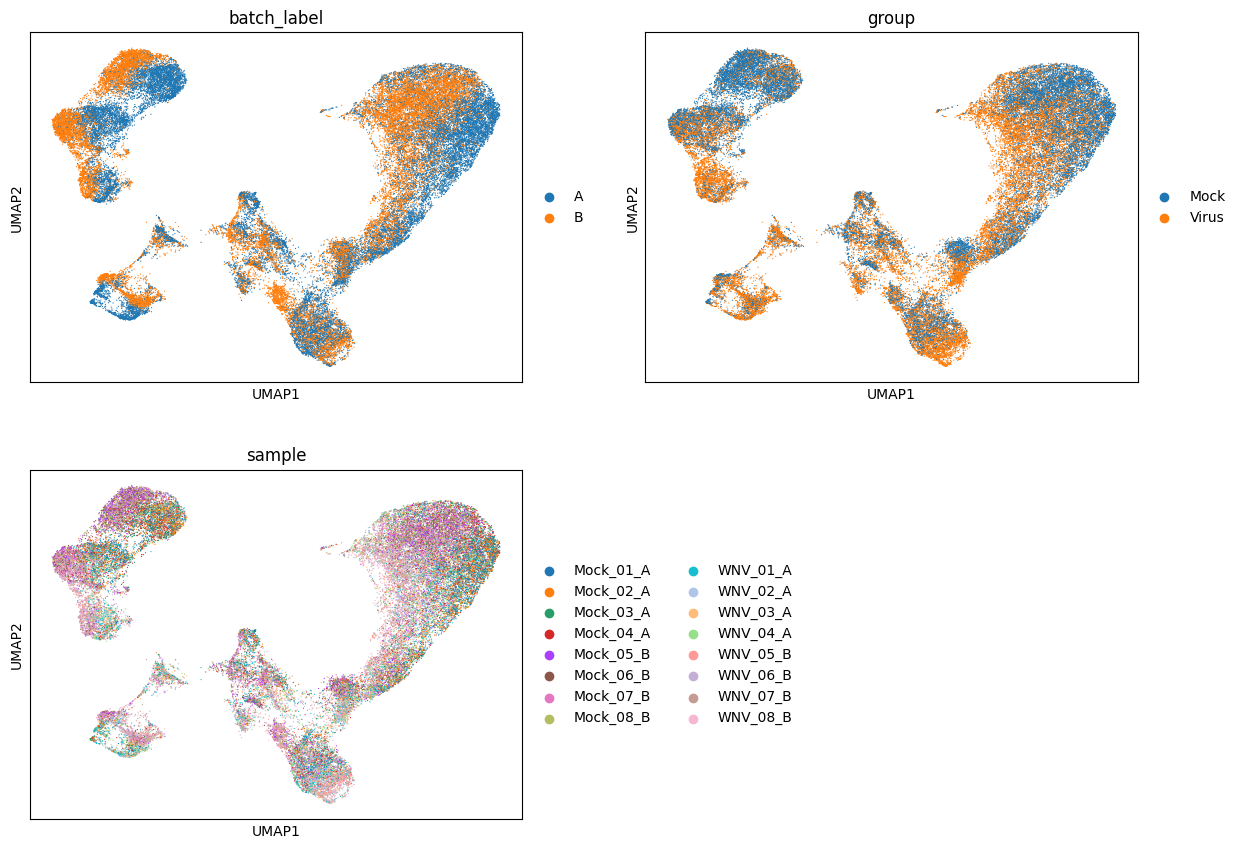

In [389]:
adata_sub = sc.pp.subsample(adata_all, n_obs = 50_000, copy = True)

sc.pp.neighbors(adata_sub)

sc.tl.umap(adata_sub, min_dist = 0.1)

sc.pl.umap(adata_sub, color = ['batch_label', 'group', 'sample'], size = 3, ncols = 2)

The most salient plot at the moment is the one showing `batch_label`, and we can see that the two batches do not overlap (remember these data are from the same biological sample and should be near identical). Let's proceed with performing batch correction to reduce the impact of this batch effect.

We start by creating a `CytoNorm` object, and adding a `FlowSOM` clusterer that will partition the data into 8 clusters. The cytonorm algorithm relies on first clustering the data so that each cluster can be aligned separately, and we only need to capture the broad cell types for now.

In [402]:
cn = cnp.CytoNorm()
fs = cnp.FlowSOM(n_clusters = 8)
cn.add_clusterer(fs)

It's useful at this point to introduce `AnnData`'s *layers* functionality. As we work with an `AnnData` object we may make changes to the data `X`, for example in transforming it or normalising it, and it can be helpful to retain multiple *versions* of the data, rather than just keep overwriting it. We can do this by creating layers within our `AnnData` object. We'll do this now so we can have seperate layers for the original, and normalised expression data.

To add a new layer, we use the `layers` attribute and use square brackets as if we're adding a new column to a DataFrame. In the example below, I just copy the existing values of `X`. When we call `adata_all`, we can see we now have a layer called `'original'`.

In [403]:
adata_all.layers['original'] = adata_all.X.copy()
adata_all

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    layers: 'original'

Next, we run the `run_anndata_setup()` method, which lets us define which layer we're going to use as the input data, the name of the layer that will contain the normalised data, and the columns in `obs` that indicate the batch and sample of each file and whether it is a reference control or not.

In [405]:
cn.run_anndata_setup(
    adata_all, 
    layer                    = 'original', 
    reference_column         = 'reference',
    batch_column             = 'batch',
    sample_identifier_column = 'sample',
    key_added                = 'normalised'
)

Looking at `adata_all` again shows an additional layer that will eventually contain the normalised data (it is just a copy of `original` at present).

In [408]:
adata_all

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    layers: 'original', 'normalised'

Now we can run the clustering we defined earlier.

In [409]:
cn.run_clustering()

We then calculate quantiles per marker, per cluster, and calculate splines that map each of these distributions to the mean distributions of the batch control files. The `normalize_data()` method then aligns the data based on the trained model.

In [410]:
cn.calculate_quantiles()
cn.calculate_splines(goal = "batch_mean")
cn.normalize_data()

c:\Python_3.10.2\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:474: UserWarning: 43 cells detected in batch 1 for cluster 3. Skipping quantile calculation. 
  warnings.warn(
c:\Python_3.10.2\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:474: UserWarning: 25 cells detected in batch 2 for cluster 3. Skipping quantile calculation. 
  warnings.warn(
c:\Python_3.10.2\lib\site-packages\cytonormpy\_normalization\_quantile_calc.py:301: RuntimeWarning: Mean of empty slice
  self.distrib = mean_func(


normalized file Mock_07_Bnormalized file Mock_03_A

normalized file WNV_01_A
normalized file Mock_04_A
normalized file WNV_02_A
normalized file Mock_08_B
normalized file Mock_06_B
normalized file Mock_02_A
normalized file WNV_07_B
normalized file WNV_05_B
normalized file WNV_04_A
normalized file WNV_06_B
normalized file WNV_03_A
normalized file WNV_08_B


If we want to normalise any files not included in the initial training, or normalize the batch control files themselves, we need to give a list of file names and corresponding list of batch memberships the the `normalize_data()` method.

In [411]:
cn.normalize_data(file_names = ['Mock_01_A', 'Mock_05_B'], batches = [1, 2])

normalized file Mock_05_Bnormalized file Mock_01_A



In [261]:
adata_all.obsm['normalised'] = adata_all.layers['normalised']

In [237]:
adata_all.obsm

AxisArrays with keys: normalised

In [313]:
adata_all.obs['cytonorm_cluster'] = cn._clustering.calculate_clusters(adata_all.layers['original']).astype('str')
adata_all.obs

filename     sample  group batch_label  batch reference  \
0        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
1        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
2        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
3        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
4        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
...                ...        ...    ...         ...    ...       ...   
159995  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159996  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159997  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159998  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159999  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   

       fsom_metacluster cytonorm_clusters cytonorm_cluster  
0             cluster_6                 4                4  
1             cluster_1                 4                4  
2             cluster_3                 3                3  
3             cluster_3                 3                3  
4             cluster_1                 4                4  
...                 ...               ...              ...  
159995        cluster_5                 3                3  
159996        cluster_8                 0                0  
159997       cluster_12                 1                1  
159998       cluster_12                 1                1  
159999        cluster_3                 3                3  

[160000 rows x 9 columns]

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


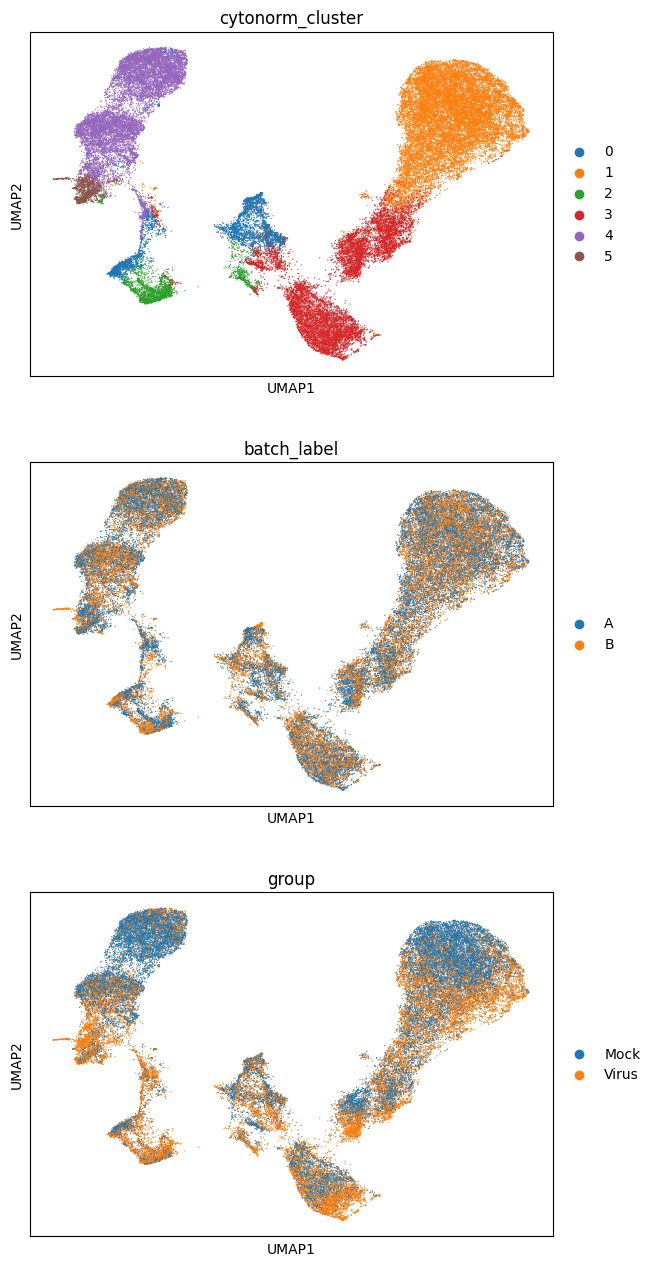

In [314]:
adata_sub = sc.pp.subsample(adata_all, n_obs = 50_000, copy = True)

sc.pp.neighbors(adata_sub, use_rep = 'normalised')

sc.tl.umap(adata_sub, min_dist = 0.1)

sc.pl.umap(
    adata_sub, 
    layer = 'normalised', 
    color = ['cytonorm_cluster', 'batch_label', 'group'], 
    size = 3, 
    ncols = 1
)

In [264]:
adata_ref = adata_all[adata_all.obs['reference'] == 'ref']
adata_ref

View of AnnData object with n_obs × n_vars = 20000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    obsm: 'normalised'
    layers: 'original', 'normalised'

In [265]:
orig = adata_ref.to_df(layer = 'original')
orig['group'] = 'original'
orig['batch'] = adata_ref.obs.batch
orig

norm = adata_ref.to_df(layer = 'normalised')
norm['group'] = 'normalised'
norm['batch'] = adata_ref.obs.batch
norm

both = pd.concat([orig, norm])
both

CD3e      CD16-32         Ly6G         CD45         CD48  \
0      1141.502801  1884.283173   631.694678  2096.491398  2345.868626   
1      1146.759063  1001.825654   911.361470  1859.862764  1385.111571   
2      1147.575687  2237.875240   844.361401  2068.902565  1974.999994   
3      1329.867442  2329.289555   791.594765  1443.450031  2116.643027   
4      1043.718253  2040.863053   342.438555  1501.455922  2602.254838   
...            ...          ...          ...          ...          ...   
49995  1093.597985  1253.195038   -48.364905  2676.159933  2916.001651   
49996  1198.776982  2779.748414  3323.263529  2151.755543  1519.962398   
49997  1473.892663  2433.838854  1060.009231  1707.809461  1881.749736   
49998  1307.985890  2601.736766  2882.050968  2027.890835   929.216557   
49999  1088.871324  2792.563676  3106.601275  1940.889623  1197.101574   

             CD11b         B220         Ly6C       group  batch  
0      1541.958951  3431.587756  1197.512280    original      1  
1      1323.273261  3219.384459  1711.602316    original      1  
2      2711.006654  1238.627796  2597.616532    original      1  
3      3098.270045  1792.858119  2867.574559    original      1  
4      2053.469957  2690.738776  1301.960150    original      1  
...            ...          ...          ...         ...    ...  
49995  1291.851753  3187.865781  1560.876894  normalised      2  
49996  3228.117012  1025.970601  2422.467398  normalised      2  
49997  2775.319616  1575.442517  2821.307012  normalised      2  
49998  3308.465222  1435.532210  2285.653496  normalised      2  
49999  3130.648391  1129.639749  2035.476600  normalised      2  

[40000 rows x 10 columns]

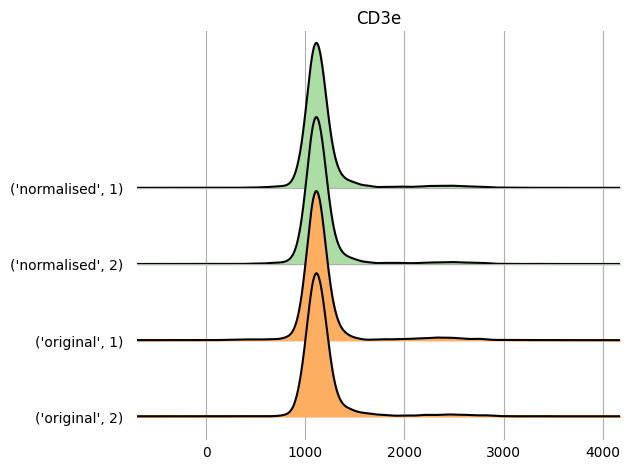

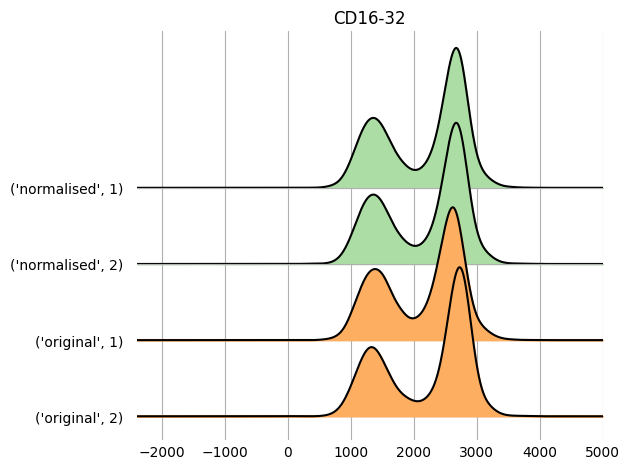

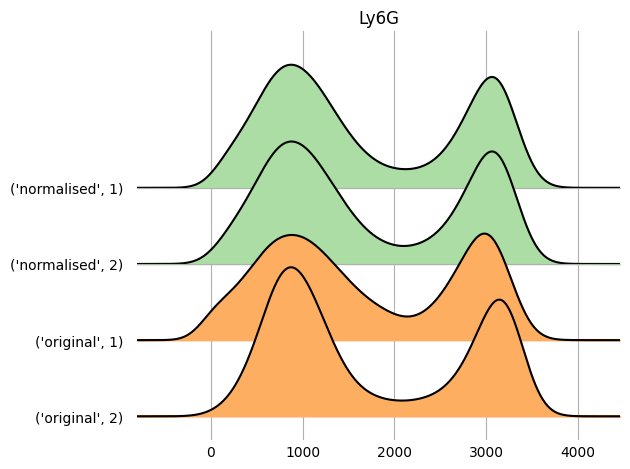

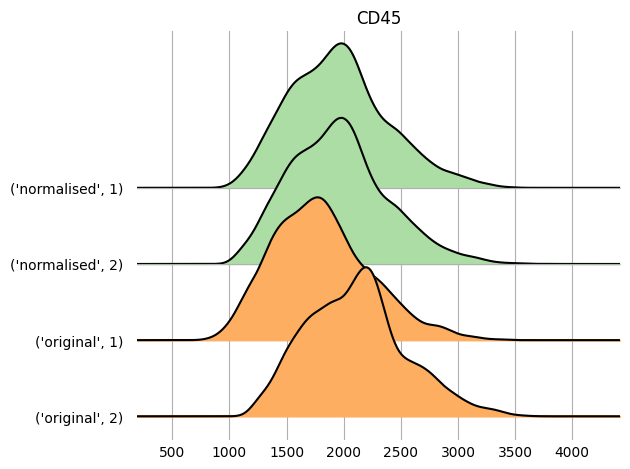

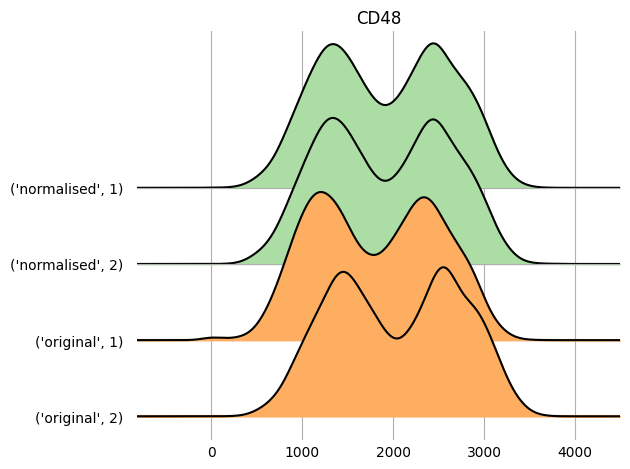

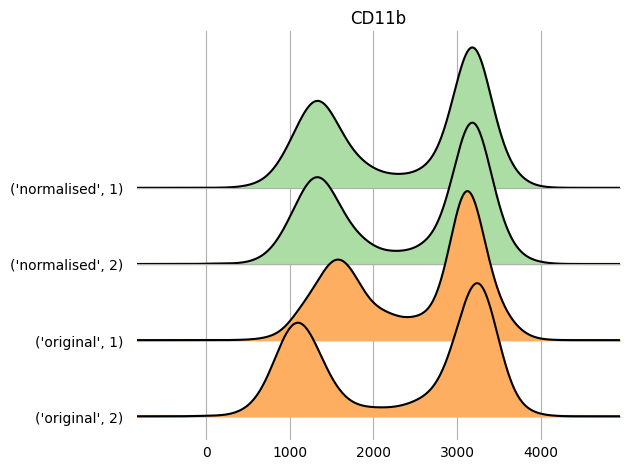

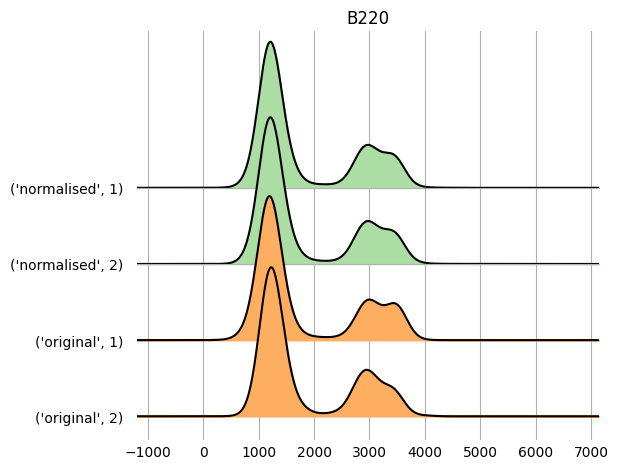

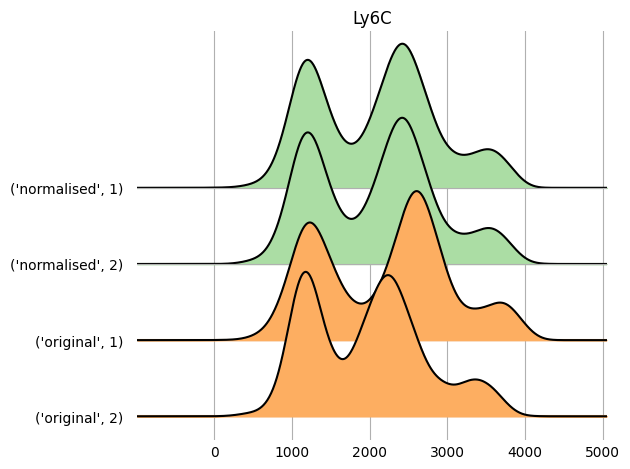

In [275]:
for param in adata.var_names.to_list():
    p = joypy.joyplot(
        both,
        title   = param,
        by      = ['group', 'batch'],
        column  = param,
        overlap = 1.5,
        grid    = True,
        color   = ['#ABDDA4', '#ABDDA4', '#FDAE61', '#FDAE61']
    )

In [277]:
adata_all.X = adata_all.layers['normalised']

In [278]:
pm.tl.flowsom_clustering(
    adata_all,
    key_added    = 'fsom_metacluster',
    som_dim      = (14, 14),
    seed         = 42,
    min_clusters = 15,
    max_clusters = 15,
    verbose      =  True
)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 654.0476407060834


Computing consensus matrices:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Python_3.10.2\lib\site-packages\kneed\knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
c:\Python_3.10.2\lib\site-packages\kneed\knee_locator.py:208: RuntimeWarning: Mean of empty slice.
  self.S * np.abs(np.diff(self.x_normalized).mean())
c:\Python_3.10.2\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python_3.10.2\lib\site-packages\consensusclustering\consensus.py:464: UserWarning: Kneedle algorithm failed to find a knee. Returning maximum number of clusters, however, it is likely that the clustering is unstable. Plot the CDFs and consensus matrices to check.
  warn(


Assigning cluster labels to cells:   0%|          | 0/160000 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference', 'fsom_metacluster'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    obsm: 'normalised'
    layers: 'original', 'normalised'

In [279]:
len(adata_all.obs['fsom_metacluster'].unique())

15

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


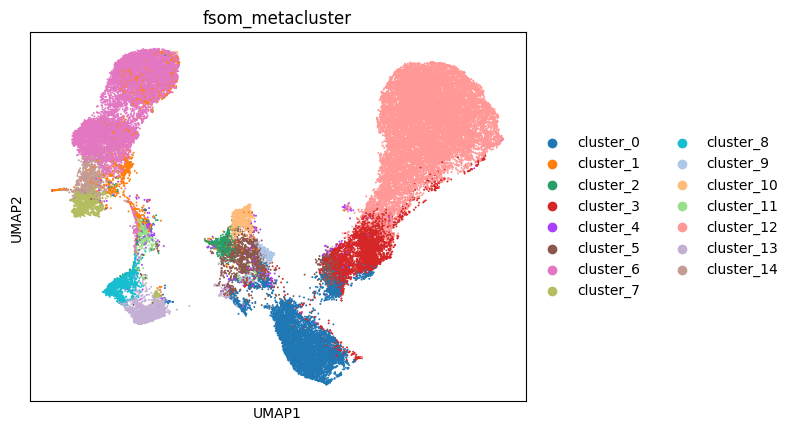

In [280]:
adata_sub = sc.pp.subsample(adata_all, n_obs = 50_000, copy = True)

sc.pp.neighbors(adata_sub)

sc.tl.umap(adata_sub, min_dist = 0.1)

sc.pl.umap(adata_sub, color = 'fsom_metacluster', size = 8)

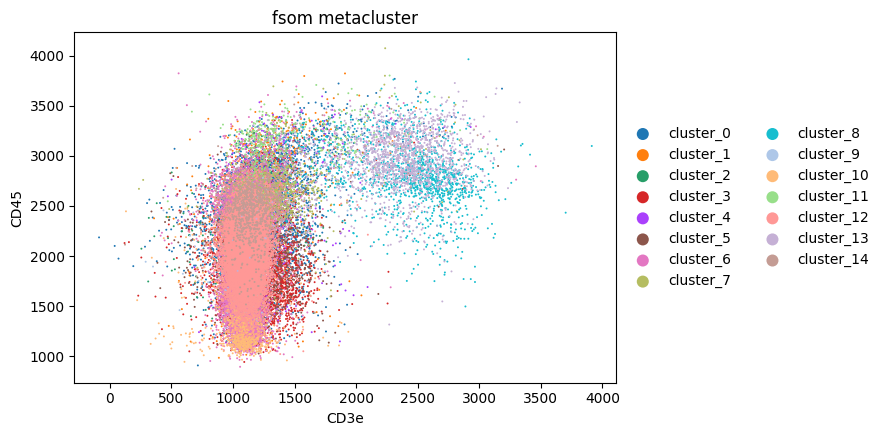

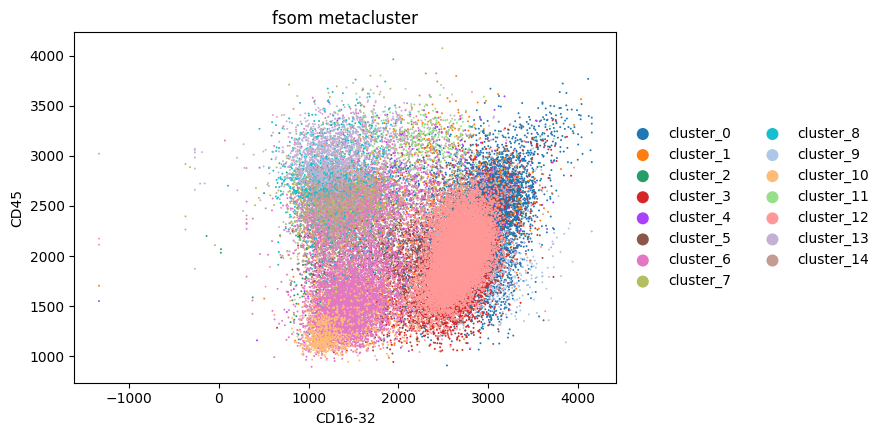

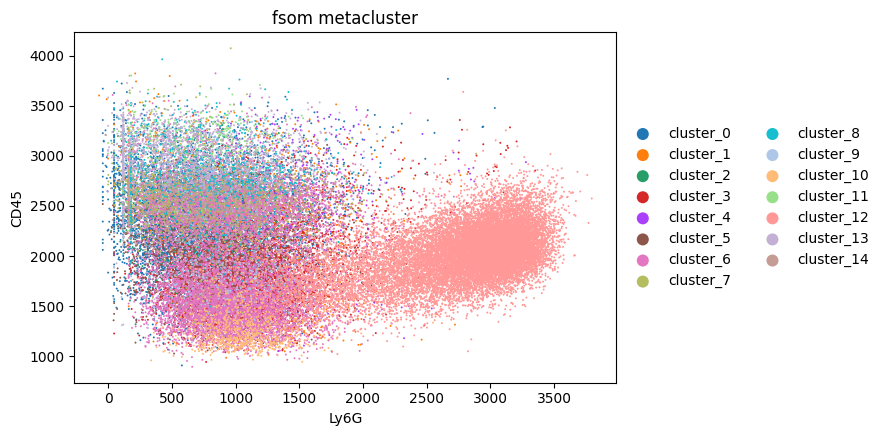

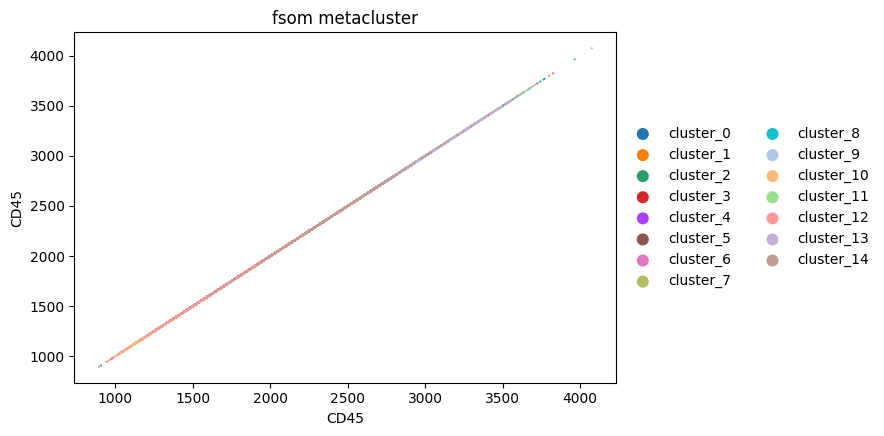

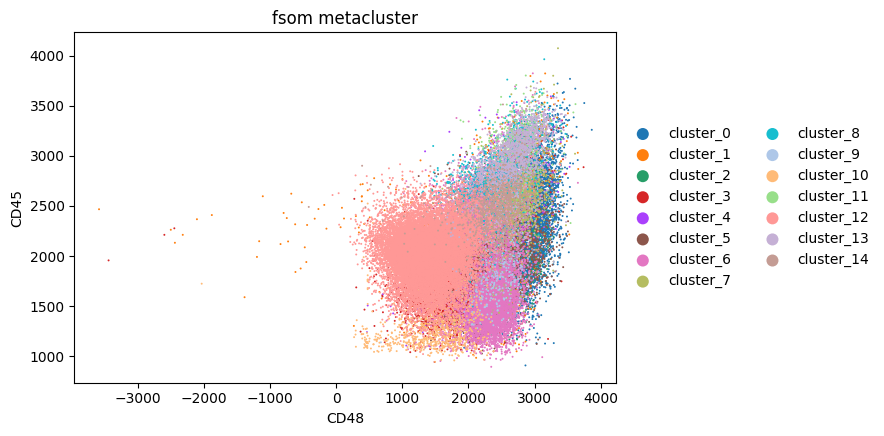

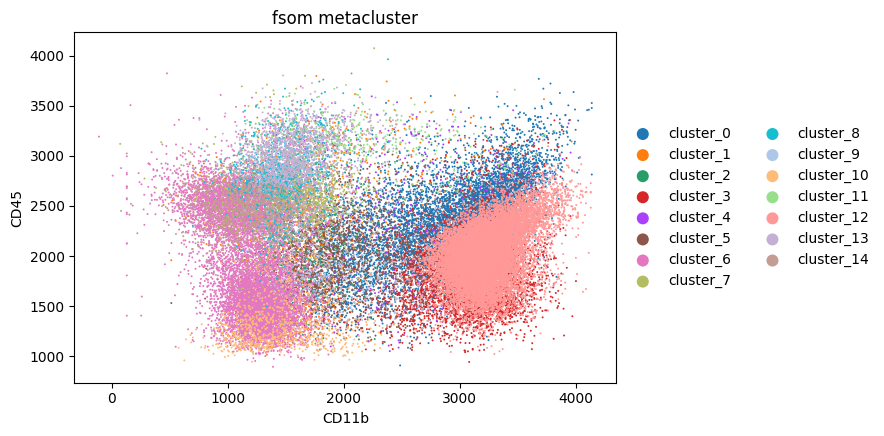

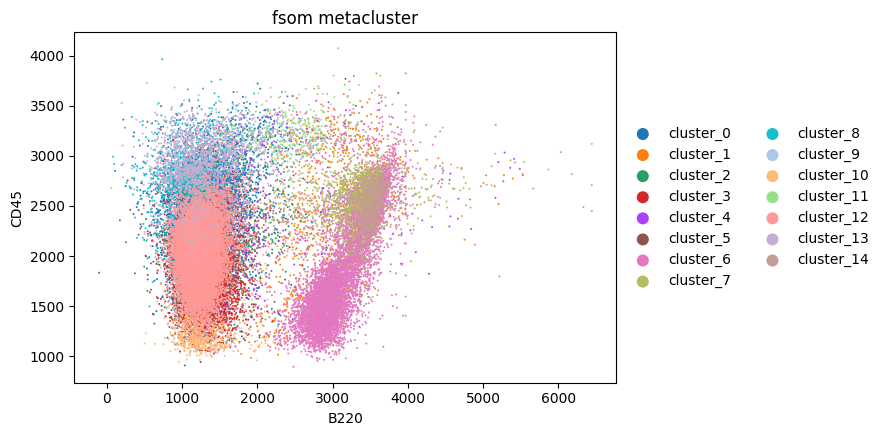

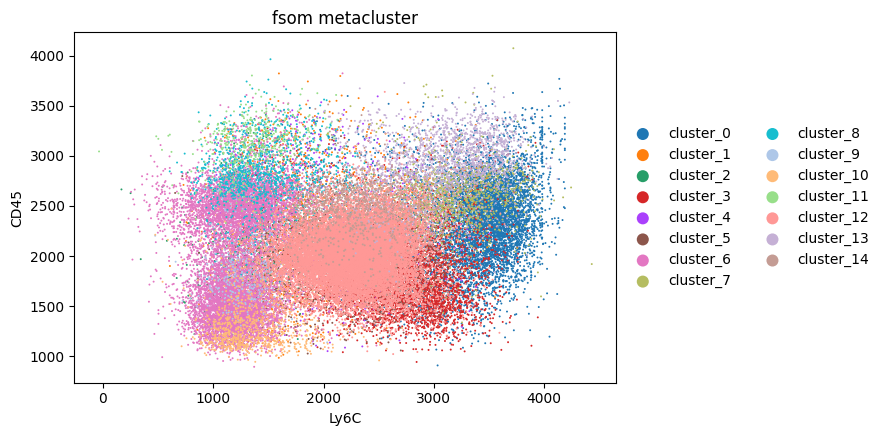

In [281]:
for param in adata_sub.var_names:
    sc.pl.scatter(adata_sub, x = param, y = 'CD45', color = 'fsom_metacluster', size = 8, )

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


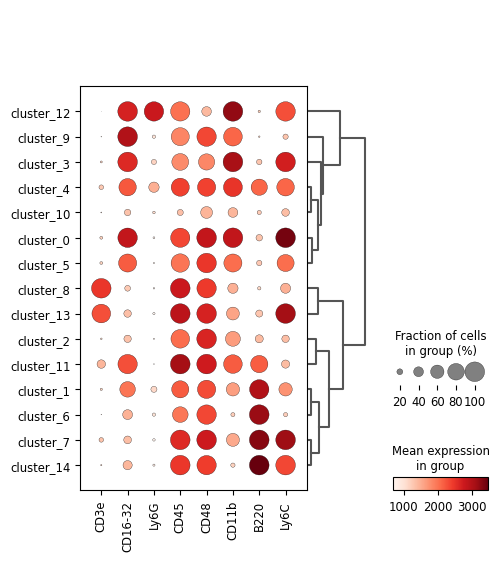

In [282]:
sc.pl.dotplot(
    adata_all, 
    var_names         = adata_all.var_names, 
    groupby           = 'fsom_metacluster', 
    dendrogram        = True,
    expression_cutoff = 1500
)

In [ ]:
adata_all

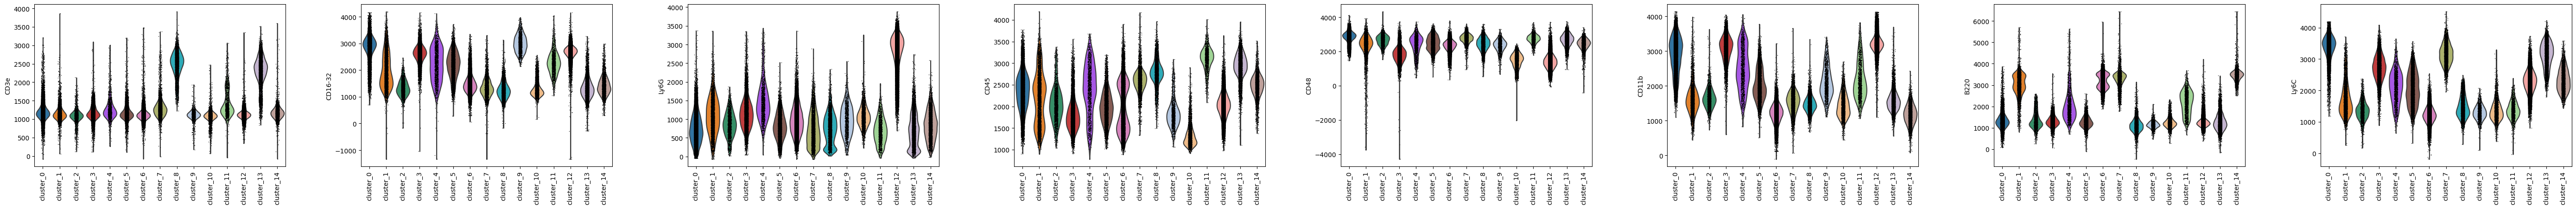

In [283]:
sc.pl.violin(
    adata_all, 
    keys     = adata_all.var_names, 
    groupby  = 'fsom_metacluster', 
    rotation = 90
)

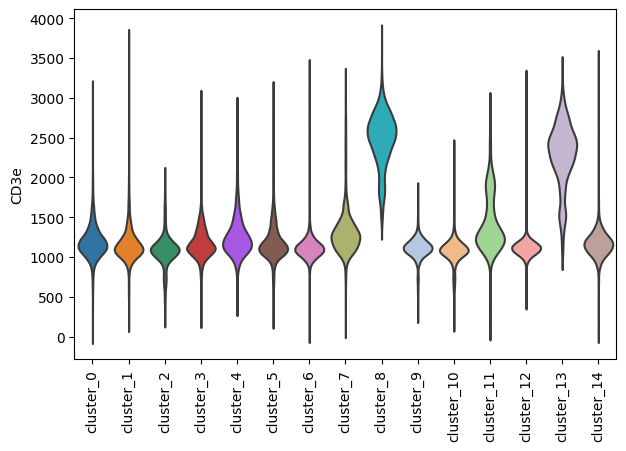

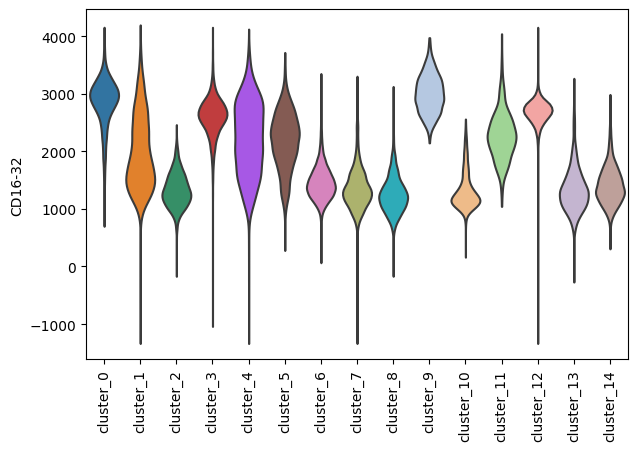

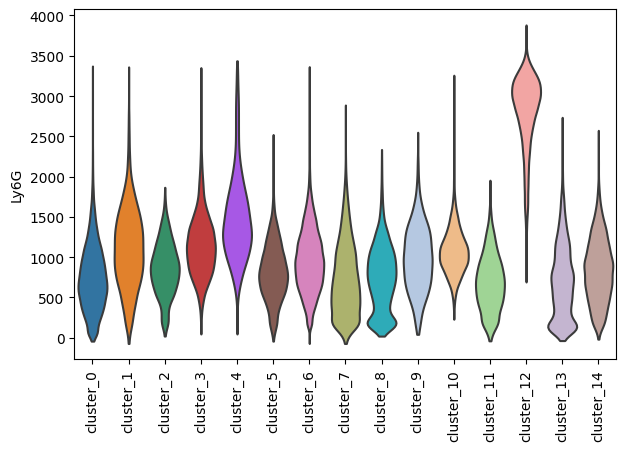

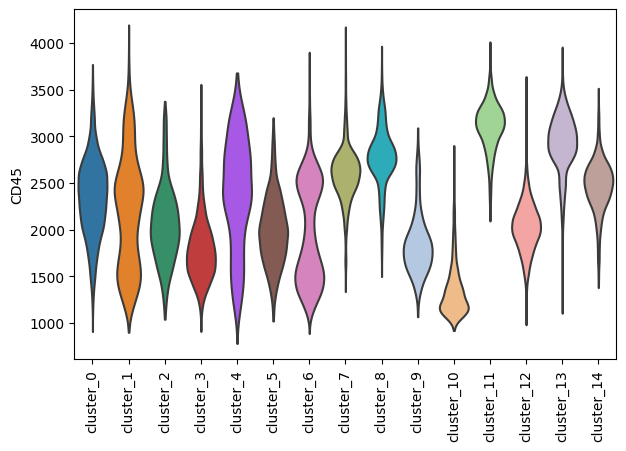

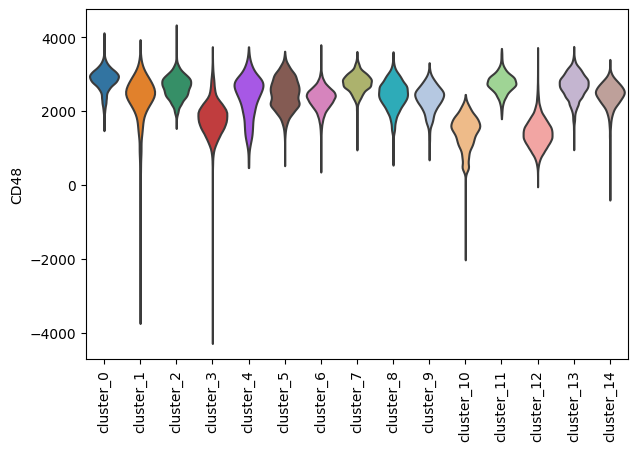

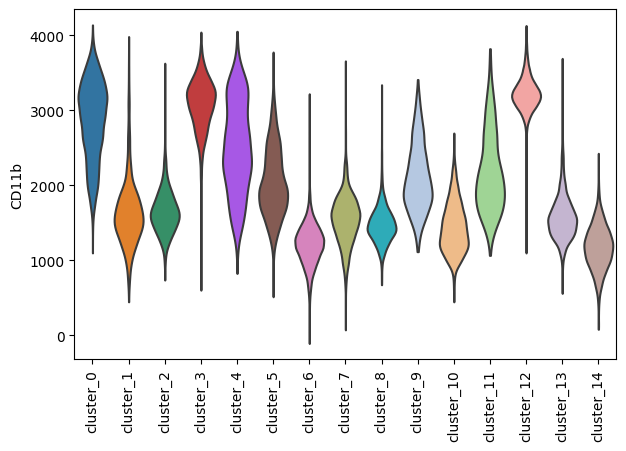

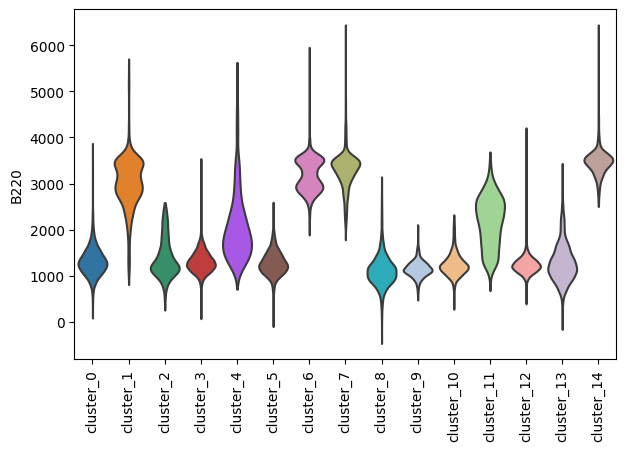

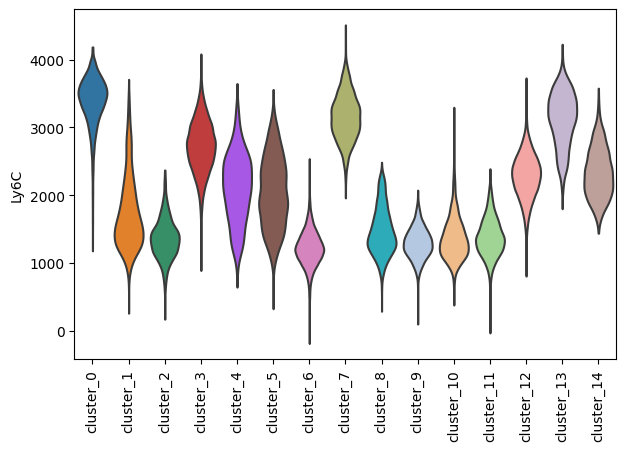

In [284]:
for param in adata_all.var_names:
    sc.pl.violin(
    adata_all, 
    keys      = param, 
    groupby   = 'fsom_metacluster', 
    rotation  = 90,
    stripplot = False    
)

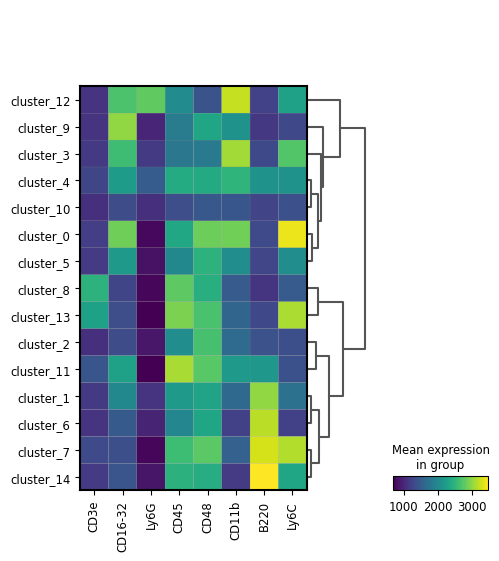

In [285]:
sc.pl.matrixplot(
    adata_all, 
    var_names  = adata_all.var_names, 
    groupby    = 'fsom_metacluster', 
    dendrogram = True
)

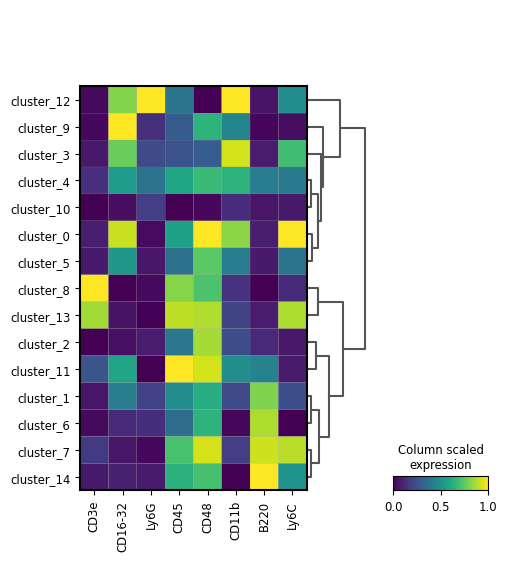

In [286]:
sc.pl.matrixplot(
    adata_all, 
    var_names      = adata_all.var_names, 
    groupby        = 'fsom_metacluster', 
    dendrogram     = True,
    standard_scale = 'var',
    colorbar_title = 'Column scaled\nexpression'
)

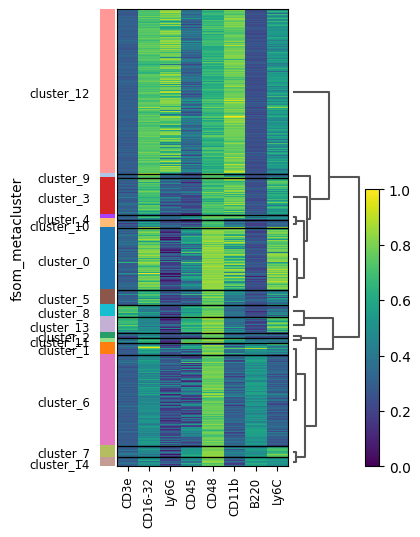

In [287]:
sc.pl.heatmap(
    adata_all, 
    var_names      = adata_all.var_names, 
    groupby        = 'fsom_metacluster', 
    standard_scale = 'var',
    dendrogram     = True
)

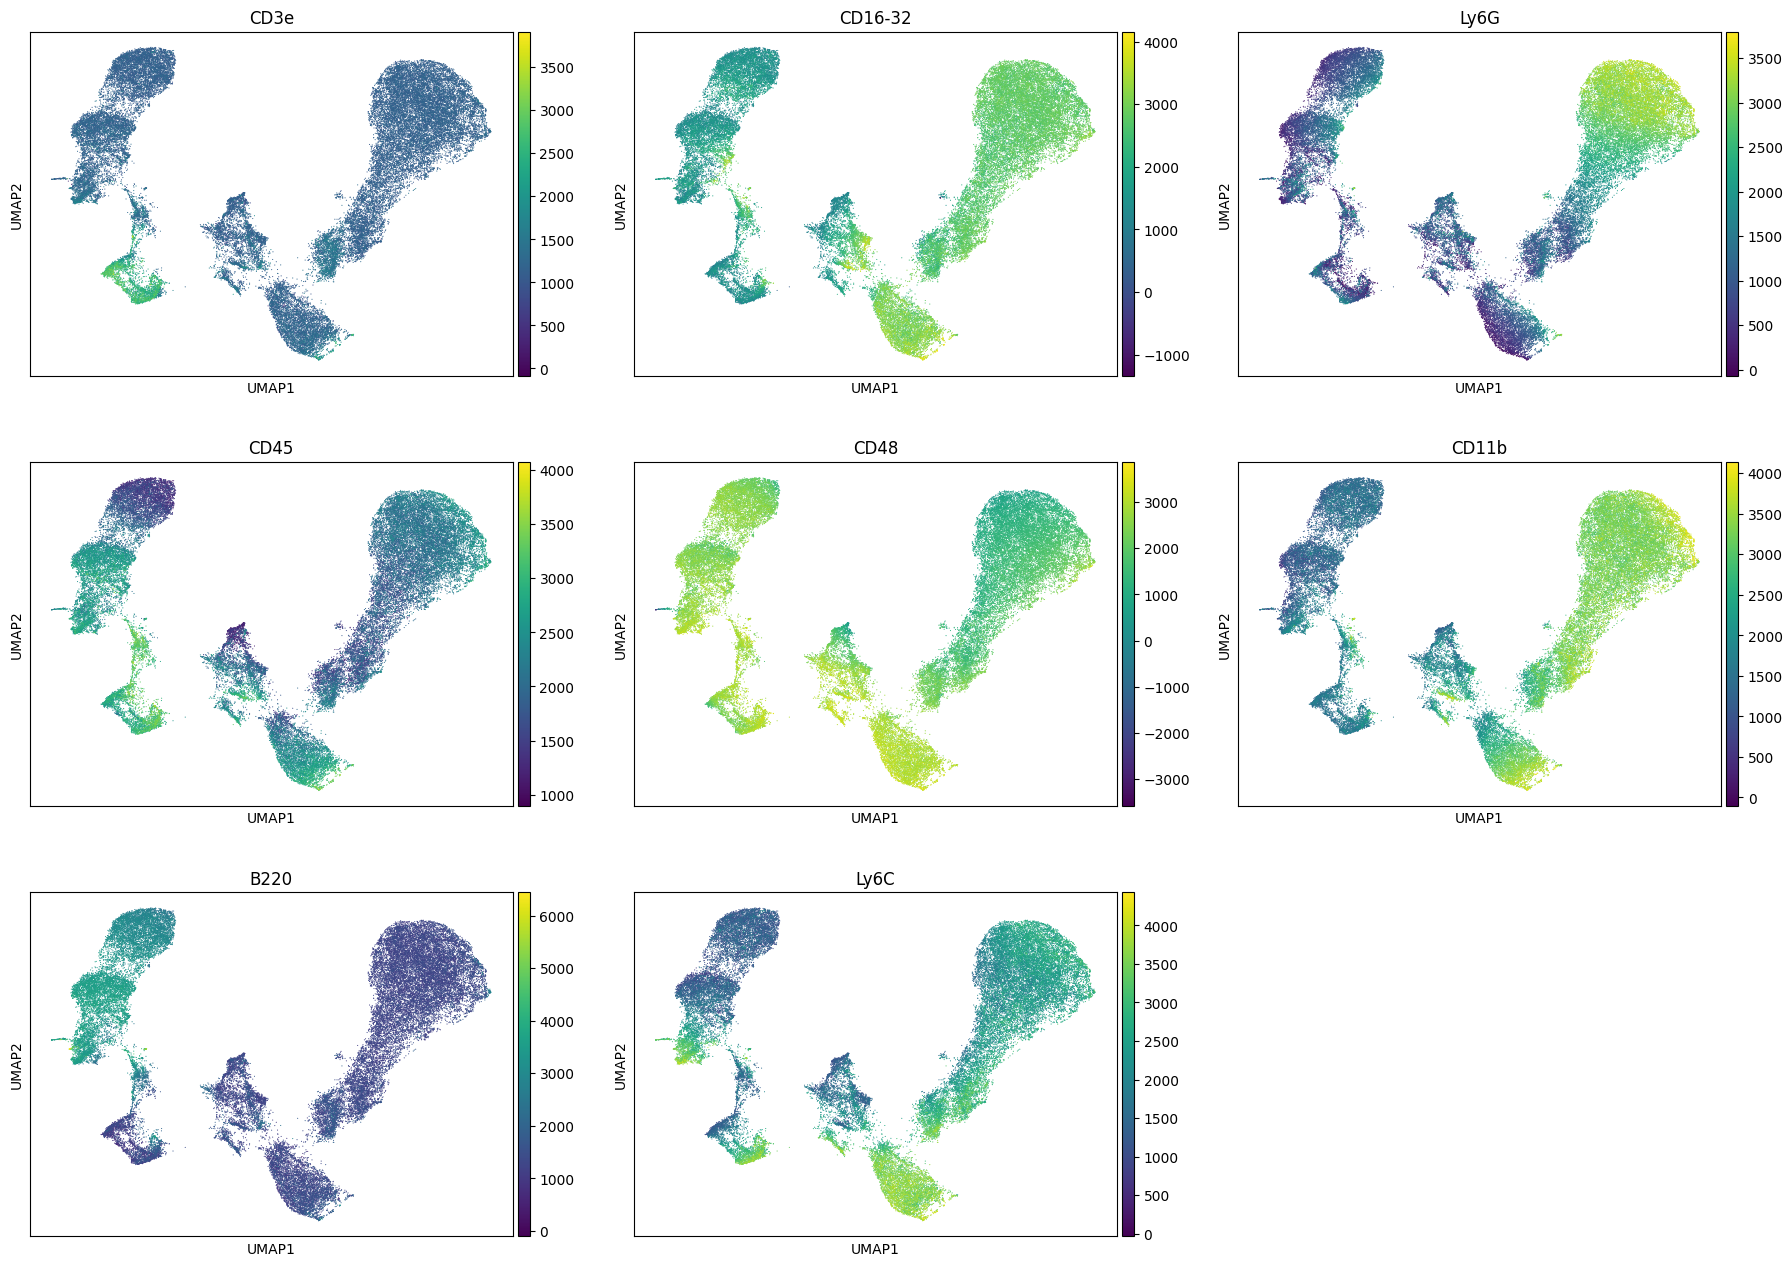

In [288]:
sc.pl.umap(
    adata_sub,
    gene_symbols = 'marker',
    color        = adata_sub.var_names,
    ncols        = 3
)

In [ ]:
annotations = {
    'cluster_0'  : 'Plasma cells',
    'cluster_1'  : 'Other/Unknown',
    'cluster_2'  : 'B cells',
    'cluster_3'  : 'Monocytes',
    'cluster_4'  : 'Mature neutrophils',
    'cluster_5'  : 'Other/Unknown',
    'cluster_6'  : 'T cells',
    'cluster_7'  : 'B cells',
    'cluster_8'  : 'Immature neutrophils',
    'cluster_9'  : 'Other/Unknown',
    'cluster_10' : 'Other/Unknown',
    'cluster_11' : 'Other/Unknown',
    'cluster_12' : 'T cells',
    'cluster_13' : 'T cells',
    'cluster_14' : 'Immature neutrophils',
}

adata_all.obs['Population'] = adata_all.obs['fsom_metacluster'].map(annotations).copy()
adata_all.obs

In [ ]:
adata_sub.obs['Population'] = adata_sub.obs['fsom_metacluster'].map(annotations).copy()
sc.pl.umap(adata_sub, color = "Population", legend_loc = 'on data')

In [ ]:


sc.pl.matrixplot(
    adata_all, 
    var_names = adata_all.var_names, 
    groupby = 'Population', 
    dendrogram = True,
    standard_scale = 'var',
    colorbar_title = 'Column scaled\nexpression'
)

In [ ]:
sc.pl.heatmap(
    adata_all, 
    var_names = adata_all.var_names, 
    groupby = 'Population', 
    standard_scale = 'var',
    dendrogram = True
)

In [ ]:
adata_all.write_csvs('data/exported/annotated')
adata_all.write('data/exported/annotated.h5ad')
adata_2 = ann.read_h5ad('data/exported/annotated.h5ad')
adata_2